# Twitter Sentiment Analysis

## Imports

In [1]:
import pandas as pd
import numpy as np
import re
import tweepy
from tweepy import OAuthHandler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('stopwords')
nltk.download("wordnet")
nltk.download('vader_lexicon')

stopwords_set = set(stopwords.words("english"))

extra_stopwords = ("rt", "url")

for word in extra_stopwords:
    stopwords_set.add(word)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\avanoostveen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\avanoostveen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\avanoostveen\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Main Class: Scrape, Clean, Tokenize and Lemmatize Tweets

In [2]:
import tweepy
import pandas as pd
from tweepy import OAuthHandler
class TwitterMain(object): 
    def __init__(self):
        # Access Credentials 
        consumer_key = 'qomm8PtOchZtPv3u0Qf7itE4w'
        consumer_secret = 'YQya6zGND5ULBePviyKWxIFRh19vqaMyhIp0f67r23aEmcLqPs'
        access_token = '958414889646788609-QKHp30udwA1hlzNxp3KAvxTFWwGgZoF'
        access_token_secret = '2GcwRYoWRs6vQL8DO9cxxkydPEpRjNJ1OZSznBuTFfD5U'
        
        try: 
            # OAuthHandler object 
            auth = OAuthHandler(consumer_key, consumer_secret) 
            # set access token and secret 
            auth.set_access_token(access_token, access_token_secret) 
            # create tweepy API object to fetch tweets 
            self.api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
            
        except tweepy.TweepError as e:
            print(f"Error: Twitter Authentication Failed - \n{str(e)}") 

    # Function to fetch tweets
    def get_tweets(self, query, maxTweets = 1000): 
        # empty list to store parsed tweets 
        tweets = [] 
        sinceId = None
        max_id = -1
        tweetCount = 0
        tweetsPerQry = 100
        
        for word in query.split():
            stopwords_set.add(word.lower())
        
        while tweetCount < maxTweets:
            try:
                if (max_id <= 0):
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry)
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                since_id=sinceId)
                else:
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1))
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1),
                                                since_id=sinceId)
                if not new_tweets:
                    print("No more tweets found")
                    break
                    
                for tweet in new_tweets:
                    if tweet.lang == 'en':
                        parsed_tweet = {} 
                        parsed_tweet['tweets'] = tweet.text.lower() 

                        # appending parsed tweet to tweets list 
                        if tweet.retweet_count > 0: 
                            # if tweet has retweets, ensure that it is appended only once 
                            if parsed_tweet not in tweets: 
                                tweets.append(parsed_tweet) 
                        else: 
                            tweets.append(parsed_tweet) 
                        
                        tweetCount = len(tweets)
#                         print("Downloaded {0} tweets".format(tweetCount))
                        max_id = new_tweets[-1].id

            except tweepy.TweepError as e:
                print("Tweepy error : " + str(e))
                break
        
        return pd.DataFrame(tweets)
    
    # Used to remove punctuation marks
    def remove_pattern(text, pattern_regex):
        r = re.findall(pattern_regex, text)
        for i in r:
            text = re.sub(i, '', text)

        return text

    def remove_emoji(text):
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        
        return emoji_pattern.sub(r'',text)

    def remove_URL(text):
        url = re.compile(r'https?://\S+|www\.\S+')
        
        return url.sub(r'URL',text)
    
    def clean_tweets(tweets_df):

        cleaned_tweets = []

        tweets_df['tweets'] = np.vectorize(TwitterMain.remove_pattern)(tweets_df['tweets'], ".[\w]*: | *RT*")
        tweets_df['tweets'] = np.vectorize(TwitterMain.remove_emoji)(tweets_df['tweets'])
        tweets_df['tweets'] = np.vectorize(TwitterMain.remove_URL)(tweets_df['tweets'])

        for index, row in tweets_df.iterrows():
            x = [word for word in row.tweets.split() if "@" not in word and word not in stopwords_set]
            cleaned_tweets.append(' '.join(x))

        return cleaned_tweets

    def tokenize(tweets_df):
        # Tokenization
        tokenized_tweets = tweets_df['tweets'].apply(lambda x: x.split())

        # Finding Lemma for each word
        word_lemmatizer = WordNetLemmatizer()
        tokenized_tweets = tokenized_tweets.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])

        #joining words into sentences (from where they came from)
        for i, tokens in enumerate(tokenized_tweets):
            tokenized_tweets[i] = ' '.join(tokens)

        return tokenized_tweets

    def bag_of_words(tweets_df):
        # BOW features
        bow_word_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
        # bag-of-words feature matrix
        bow_word_feature = bow_word_vectorizer.fit_transform(tweets_df['tweets'])

        return bow_word_vectorizer, bow_word_feature
    
    def sentiment(text):
        sid = SentimentIntensityAnalyzer()
        polarity_scores = sid.polarity_scores(text)
        if polarity_scores['neg'] > polarity_scores['pos']:
            return 'negative'
        else:
            return 'positive'
    
    def frequencies(df):
        all_words = []
        for line in list(df['tweets']):
            words = line.split()
            for word in words:
                all_words.append(word.lower())

        # create a word frequency dictionary
        return Counter(all_words)

    def cloud(df):
        # create a word frequency dictionary
        wordfreq = TwitterMain.frequencies(df)
        # draw a Word Cloud with word frequencies
        wordcloud = WordCloud(
            background_color='white',
            max_words=2000,
            stopwords=stopwords
           ).generate_from_frequencies(wordfreq)
        plt.figure(figsize=(10,9))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()

## Call relevant functions

In [3]:
# Retrieve Tweets based on Query
tweets_df = TwitterMain.get_tweets(TwitterMain(), "ING Bank")

# Make sure all Tweets are string types
tweets_df['tweets']=tweets_df['tweets'].apply(str)

# Clean Tweets (Remove stopwords, punctuation marks, usernames, emojis and url's)
tweets_df['tweets'] = TwitterMain.clean_tweets(tweets_df)
tweets_df['tweets'] = tweets_df['tweets'].str.replace("[^a-zA-Z\s]", "")

# Tokenize and Lemmatize Tweets
tweets_df['tweets'] = TwitterMain.tokenize(tweets_df)

# Create Bag of Words vectorizer and feature
bow_word_vectorizer, bow_word_feature = TwitterMain.bag_of_words(tweets_df)

# tweets_df

No more tweets found


## Sentiment Analysis

In [4]:
tweets_df["Sentiment"]=""

counter = 0

for text in tweets_df["tweets"]:
    tweets_df["Sentiment"][counter] = TwitterMain.sentiment(text)
    counter +=1

## Visualisations

### Wordcloud

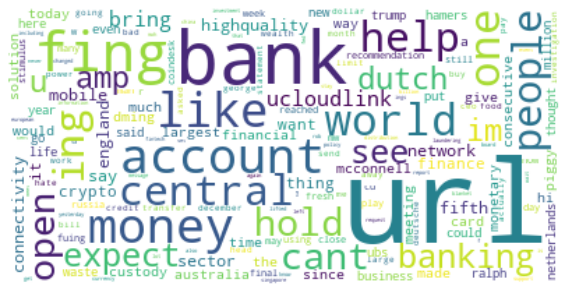

In [5]:
TwitterMain.cloud(tweets_df)
wordfreq = TwitterMain.frequencies(tweets_df)

### Histograms

In [6]:
df = pd.DataFrame.from_dict(wordfreq, orient='index').reset_index()
df.columns = ['Word', 'Frequency']
df = df.sort_values(by = "Frequency", ascending = False).reset_index(drop=True)

fig = px.histogram(df[2:27], x="Word", y = "Frequency", title = "Word Frequency", nbins = 20)
fig.show()

## Positive Negative

In [7]:
tweets_df_positive = tweets_df[tweets_df.Sentiment == 'positive']
tweets_df_negative = tweets_df[tweets_df.Sentiment == 'negative']

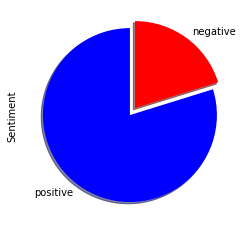

In [8]:
tweets_df["Sentiment"].value_counts().plot(kind='pie', 
                                           explode = (0, 0.1),colors = ["blue", "red"], shadow=True, startangle=90)

### Wordcloud Positive

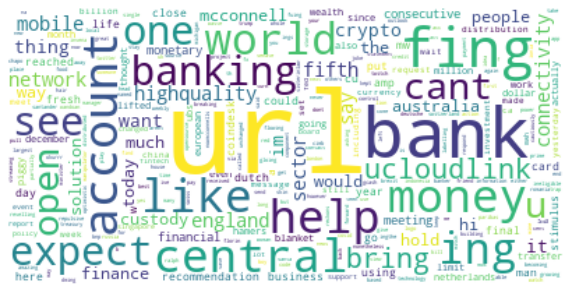

In [9]:
wordfreq_pos = TwitterMain.frequencies(tweets_df_positive)
TwitterMain.cloud(tweets_df_positive)

### Wordcloud Negative

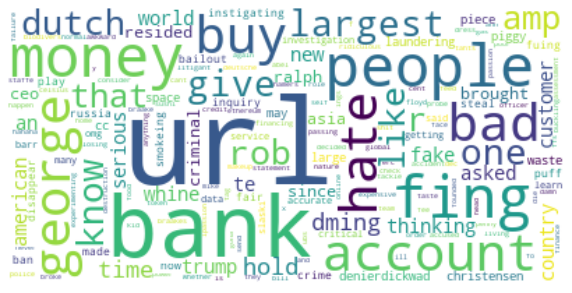

In [10]:
wordfreq_neg = TwitterMain.frequencies(tweets_df_negative)
TwitterMain.cloud(tweets_df_negative)

### Histograms

In [11]:
df_pos = pd.DataFrame.from_dict(wordfreq_pos, orient='index').reset_index()
df_pos.columns = ["Word", "Frequency"]
df_pos = df_pos.sort_values(by = "Frequency", ascending = False).reset_index(drop=True)

df_neg = pd.DataFrame.from_dict(wordfreq_neg, orient='index').reset_index()
df_neg.columns = ["Word", "Frequency"]
df_neg = df_neg.sort_values(by = "Frequency", ascending = False).reset_index(drop=True)

df_neg["Frequency"]=df_neg["Frequency"].apply(lambda x: x*-1)

<ipython-input-12-d5cb09fba0ec>:5: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



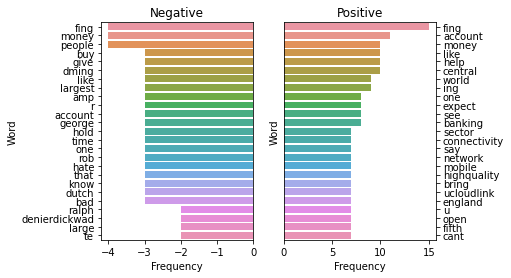

In [12]:
fig, ax =plt.subplots(1,2)
bar_plot = sns.barplot(x='Frequency', y='Word', data=df_pos[2:27], ax = ax[1]).set_title("Positive")
bar_plot = sns.barplot(x='Frequency', y='Word', data=df_neg[2:27], ax = ax[0]).set_title("Negative")
ax[1].yaxis.tick_right()
fig.show()